In [1]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask
import util

In [12]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


## Spin up dask cluster

In [13]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster(project='UCUC0006')
cluster.scale(32)
cluster

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43078 instead
  http_address["port"], self.http_server.port


In [14]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.14:32975 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/43078/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Load Data

In [15]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']].sel(length = 40)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## Compute the properties of the climate



In [16]:
## Compute the properties of the unperturbed climate
# The mean
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
# Standard deviation of anomalies
ds_ctrl_std = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)

## Compute the properties of the current climate: 2000-2030
# The mean
ds_curr_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute()
)

## SET UP Datasets for Polar Plots

In [10]:
v = 'KGP'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],
        
        f'toe_{v}': dst[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:         (nlat: 93, nlon: 321)
Coordinates:
    length          float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT            (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG           (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 138.3 139.4
    dso_KGP_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsm_KGP_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KGP_mean_delta  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dssa_KGP_std    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    toe_KGP         (nlat, nlon) float64 dask.array<chunksize=(47, 161), meta=np.ndarray>

In [21]:
v = 'KGP'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp_gp = util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],
        
        f'toe_{v}': dst[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp_gp

v = 'Chl_surf'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp_chl = util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],
        
        f'toe_{v}': dst[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))

v = 'SST'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp_sst = util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],
        
        f'toe_{v}': dst[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))


In [ ]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
plt_ttl = 'SST: Mean-Std-Change'

vp1 = 'dso_SST_mean'
vp2 = 'dsm_SST_mean'
vp3 = 'dssa_SST_std'
unit = '°C'

vp4 = 'SST_mean_delta'
vc = 'KGP_mean'

################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)

t1, t2, t3 = '1990-2020 Mean State', 'Standard Deviation', '$\Delta$ by 2100'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = std_plot(dsp[vp3],lines = False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

# ################### COLORBAR FOR 2 LEFT PLOTS ############################
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16,rotation=30)

################### FAR RIGHT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], lines=False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

# --------------------------------------------------------
title = (f'{plt_ttl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

## Matplotlib Details

In [37]:
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

# KGP 
level_p_gp = [0, 0.219]
levels_chng_gp = np.linspace(-0.16, 0.16, 11)
labels_diff_gp = [-0.13, -0.06, 0, 0.06, 0.13]
level_t_gp = [2020, 2099]
# Control, Future, STDEV 
levels_gp = np.linspace(-0.05, 0.22, 21)
labels_gp = [-0.04, 0, 0.04, 0.9, 0.13, 0.17,0.21] #-0.04, 0.0, 0.04, 0.09, 0.13, 0.17, 0.21
levels_std_gp = np.linspace(0, 0.1, 11)
labels_std_gp = [0.0, 0.015, 0.03,0.45,0.60,0.75,0.9]
cmap_chng_gp = cmocean.cm.delta
cmap_gp = cmocean.cm.delta
cmap_std_gp = cmocean.tools.crop_by_percent(cmocean.cm.rain, 35, which='max', N=None)

In [18]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [19]:
def epoch_plot(da, level, cmapper, normed, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=level, #extend = 'both',
                     norm=normed,
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
#     # contour lines
#     cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
#                     colors='k',
#                     #levels=levels,#_cont,
#                     linewidths=0.05,
#                     transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [35]:
def change_plot(da, dc, level, cmapper, normed, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=level,
                     norm=normed,
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, dc,
                    colors='k', 
                    levels=level_p,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [34]:
def std_plot(da, level, cmapper):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=level,
                     #norm=MidpointNormalize(midpoint=0.),
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
  
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

TypeError: std_plot() takes 3 positional arguments but 4 were given

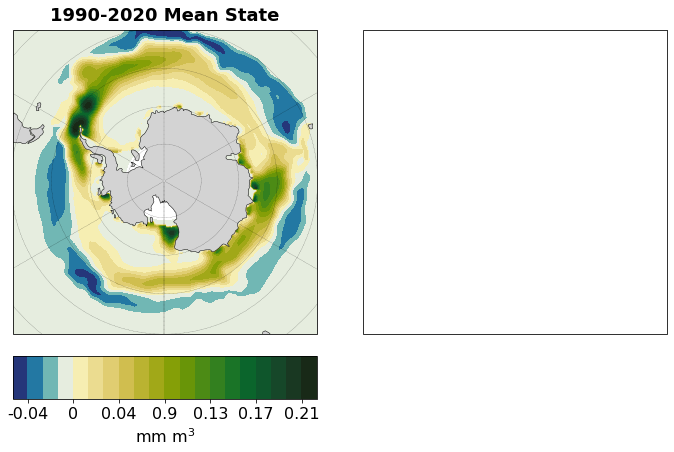

In [36]:
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, t3 = '1990-2020 Mean State', 'Standard Deviation', '$\Delta$ by 2100'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
dsp = dsp_gp
plt_ttl = 'KGP: Mean-Std-Change'

vp1 = 'dso_KGP_mean'
vp2 = 'dsm_KGP_mean'
vp3 = 'dssa_KGP_std'
unit = 'mm m$^3$'

vp4 = 'KGP_mean_delta'
vc = 'dsm_KGP_mean'

vp5 = 'toe_KGP'
unit2 = 'Years'
normal = MidpointNormalize(midpoint=0.)

level, cmapper, normed = levels_gp, cmap_gp, normal


cf = epoch_plot(dsp[vp1],level, cmapper, normed,lines = False)

ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels_gp)
cb.ax.tick_params(labelsize=16)

################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = std_plot(dsp[vp3],levels_std_gp,cmap_std_gp, MidpointNormalize(midpoint=0.))
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

# ################### COLORBAR FOR 2 LEFT PLOTS ############################
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### 2nd RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], dsp[vc], level_chng_gp, )
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels_diff_gp)
cb.ax.tick_params(labelsize=16)
# --------------------------------------------------------
# title = (f'{plt_ttl}')
# path = 'figures/'
# file = '.pdf'
# plt.savefig(path + title + file, bbox_inches='tight')

# Repeat for SST

In [278]:
v = 'SST'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        'KGP_mean': dsm['KGP'],
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        f'toe_{v}': dst[v],        
        f'dssa_{v}_std': dssa[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:         (nlat: 93, nlon: 321)
Coordinates:
    length          float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT            (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG           (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 138.3 139.4
    KGP_mean        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dso_SST_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsm_SST_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SST_mean_delta  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    toe_SST         (nlat, nlon) float64 dask.array<chunksize=(93, 161), meta=np.ndarray>
    dssa_SST_std    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [279]:
 print(dsp.dso_SST_mean.mean());

# print(dsp.dssa_SST_std.min());
# print(dsp.dssa_SST_std.max());

<xarray.DataArray 'dso_SST_mean' ()>
array(6.86697233)
Coordinates:
    length   float64 40.0


## Set Levels etc 

In [280]:
np.arange(-3,6,.75)
#np.linspace(-3,6,11)

array([-3.  , -2.25, -1.5 , -0.75,  0.  ,  0.75,  1.5 ,  2.25,  3.  ,
        3.75,  4.5 ,  5.25])

In [281]:
# Control
levels = np.arange(-1.5,5.25,.5)#np.linspace(-1.5, 10, 23)
# STDEV 
levels_std = np.linspace(0, 0.1, 11)
#labels_std = [0.0, 0.015, 0.03,0.45,0.60,0.75,0.9]
# SST Change 
level_p = [0, 0.219]
levels_chng = np.arange(-3,6,.75)
labels_diff = []
levels_cont = [-1, 5]

#Colors
cmap = cmocean.cm.thermal
cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)

#Standard
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

In [282]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [283]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels,
                     extend = 'both',
                     #norm=MidpointNormalize( midpoint=0.),
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='gray',
                    levels=levels_cont,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [284]:
def change_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k', 
                    levels=level_p,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [285]:
def std_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     #levels=levels_std,
                     #norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap_std,
                     transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

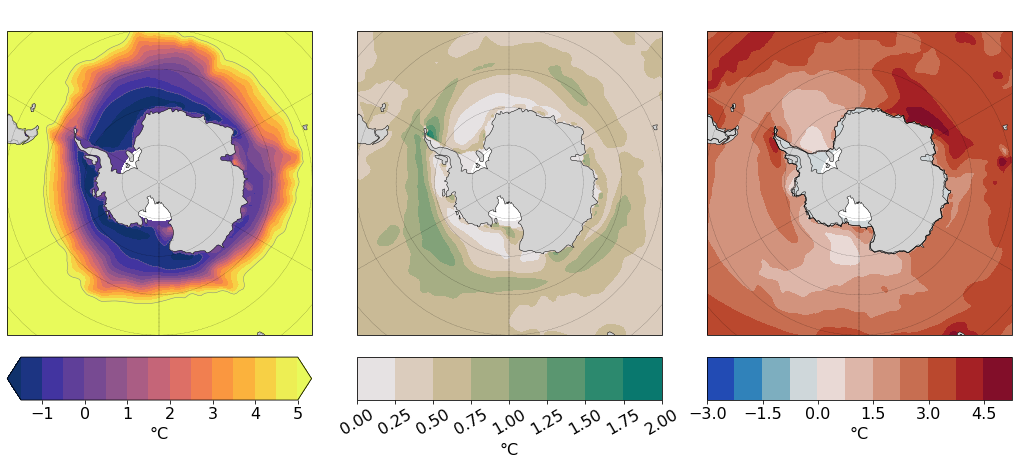

In [286]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
plt_ttl = 'SST: Mean-Std-Change'

vp1 = 'dso_SST_mean'
vp2 = 'dsm_SST_mean'
vp3 = 'dssa_SST_std'
unit = '°C'

vp4 = 'SST_mean_delta'
vc = 'KGP_mean'

################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, t3 = '1990-2020 Mean State', 'Standard Deviation', '$\Delta$ by 2100'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = std_plot(dsp[vp3],lines = False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

# ################### COLORBAR FOR 2 LEFT PLOTS ############################
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16,rotation=30)

################### FAR RIGHT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], lines=False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

# --------------------------------------------------------
title = (f'{plt_ttl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

___
# Repeat for Chl

In [287]:
v = 'Chl_surf'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        'KGP_mean': dsm['KGP'],
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        f'toe_{v}': dst[v],        
        
        f'dssa_{v}_std': dssa[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:              (nlat: 93, nlon: 321)
Coordinates:
    length               float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                 (nlat, nlon) float64 -79.22 -79.22 ... -30.08 -30.08
    TLONG                (nlat, nlon) float64 -220.6 -219.4 ... 138.3 139.4
    KGP_mean             (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dso_Chl_surf_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dsm_Chl_surf_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Chl_surf_mean_delta  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    toe_Chl_surf         (nlat, nlon) float64 dask.array<chunksize=(93, 161), meta=np.ndarray>
    dssa_Chl_surf_std    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [288]:
print(dsp.dssa_Chl_surf_std.min().values)
print(dsp.dssa_Chl_surf_std.max().values)
print(dsp.dssa_Chl_surf_std.mean().values)

0.0
3.245998799531382
0.1511746981583511


In [289]:
np.linspace(0,2,11)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

### Set up levels

In [290]:
# print(dsp.Chl_surf_mean_delta.min())
# print(dsp.Chl_surf_mean_delta.max())
# print(dsp.Chl_surf_mean_delta.mean())

In [291]:
#np.arange(-1.8,1.8,.2)
np.linspace(-1.8,1.8,13)



array([-1.80000000e+00, -1.50000000e+00, -1.20000000e+00, -9.00000000e-01,
       -6.00000000e-01, -3.00000000e-01, -2.22044605e-16,  3.00000000e-01,
        6.00000000e-01,  9.00000000e-01,  1.20000000e+00,  1.50000000e+00,
        1.80000000e+00])

In [292]:
# Control
levels = np.logspace(-2.3,.815,11)
norm = colors.LogNorm(vmin=levels[0], vmax=levels[-1])
labels = [0.005, 0.021, 0.088, 0.37, 1.6, 6.5]
# STDEV 
levels_std = np.linspace(0,2,11)
norm_std = colors.LogNorm(vmin=levels_std.min(), vmax=levels_std.max())

#labels_std = [0.0, 0.015, 0.03,0.45,0.60,0.75,0.9]

# CHL Change 
level_p = [0, 0.219]
levels_chng =np.linspace(-1.8,1.8,13)#np.arange(-1.8,1.8,.2) #[-3.4, -2.6, -1.8, -0.9, -0.08, 0.8, 1.6]
levels_cont = [0, 0.5]

#Colors
cmap = cmocean.cm.dense
#cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

### Run Plotting Functions

In [293]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels, #extend = 'both',
                     norm=norm,
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='gray',
                    levels=levels_cont,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [294]:
def change_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())

    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [295]:
def std_plot(da):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_std,
                     #norm=norm_std,
                     cmap=cmap_std,
                     transform=ccrs.PlateCarree())
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

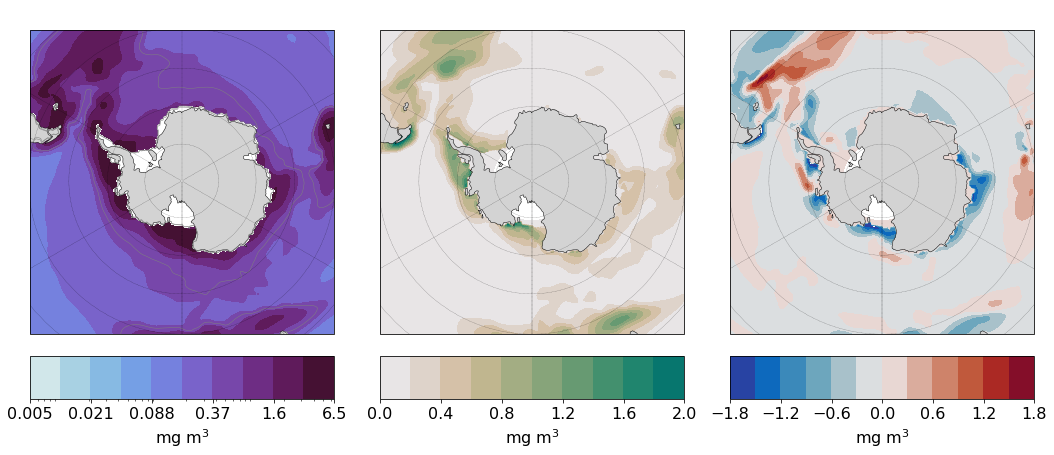

In [297]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
plt_ttl = 'Chl: Mean-Std-Change'

vp1 = 'dso_Chl_surf_mean'
vp2 = 'dsm_Chl_surf_mean'
vp3 = 'dssa_Chl_surf_std'
unit = 'mg m$^3$'

vp4 = 'Chl_surf_mean_delta'
vc = 'KGP_mean'

vp5 = 'toe_Chl_surf'
unit2 = 'Years'
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, t3 = '1990-2020 Mean State', 'Standard Deviation', '$\Delta$ by 2100'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = std_plot(dsp[vp3])
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

# ################### COLORBAR FOR 2 LEFT PLOTS ############################
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### FAR RIGHT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], lines=False)
ax.set_title('  ', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

# --------------------------------------------------------
title = (f'{plt_ttl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')